# Preparations...

### Imports

In [15]:
import numpy as np
from numpy.linalg import inv
from scipy.linalg import sqrtm, eigh
import networkx as nx
import matplotlib.pyplot as plt

### Read Data

In [18]:
example1 = './data/example1.dat'

with open(example1) as file:
  lines = [line.rstrip().split(',') for line in file]

lines = np.array(lines, dtype=int) - 1
lines

array([[  0,   1],
       [  0,   2],
       [  0,   3],
       ...,
       [215, 234],
       [212, 234],
       [240, 234]])

### Draw the graph

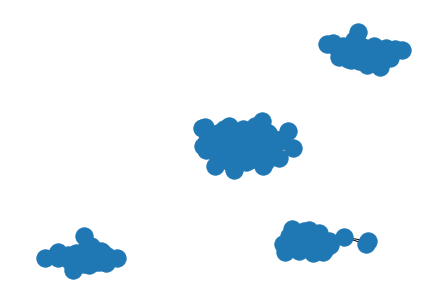

In [45]:
g = nx.Graph()

for edge in lines:
  g.add_edge(edge[0], edge[1])

# Drawing the graph
nx.draw(g)
plt.show()

# Testing Functions for the K-eigenvector Algorithm

## 1. Form Affinity Matrix A

Affinity Matrix is another word for Adjacency Matrix if I understand it correctly? https://math.stackexchange.com/questions/3275579/the-similarity-matrix-of-graph-laplacian-matrix-has-different-names-whats-the

In [32]:
maxID = lines.max()

A = np.zeros(shape=(maxID + 1, maxID + 1))

for edge in lines:
  fromNode = edge[0]
  toNode = edge[1]

  A[fromNode][toNode] = 1

A

array([[0., 1., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## 2. Construct Laplacian Matrix L

Hopefully I constructed Normalized Laplacian Matrix correctly :))))    

Please double check :')

In [33]:
D = np.diag(A.sum(axis=1))
L = ((sqrtm(inv(D))).dot(A)).dot(sqrtm(inv(D)))

def check_symmetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)

check_symmetric(L)

True

## 3. Form Matrix X of the k largest eigenvectors of L

Eigenvectors are returned in the right form: each column is one eigenvector if I understand it correctly. I have not chosen "orthogonal" vectors if eigenvalues are repeated -> `TODO`!  

Also, what in the world do they mean with "find the k `largest` eigenvectors"? Is it the eigenvectors corresponding to the largest eigenvalues, as I have picked now?

In [131]:
k = 4
eigenVals, eigenVecs = eigh(L, eigvals=(len(L) - k - 1, len(L) - 1))
X = eigenVecs
eigenVals

array([0.83232272, 1.        , 1.        , 1.        , 1.        ])

## 4. Form Matrix Y by renormalizing X

Since numpy's function `eigh` already returns normalized eigenvectors, this step is not needed. Furthermore, since we already get normalized eigenvectors, this step causes issues if `k` is too small since the denominator reaches close to, or equal to, 0,

In [133]:
Y = np.zeros(shape=X.shape)
for i in range(Y.shape[0]):
  renomalizationFactor = np.sqrt(np.sum(np.square(X[i])))
  for j in range(Y.shape[1]):
    Y[i][j] = X[i][j] / renomalizationFactor

len(Y)

241

## 5. Run K-means clustering algorithm on Y

K-means returns 241 assigned colors. Each color `colors[i]` is meant to be assigned to `node[i]`!

In [61]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=k)
kmeans.fit(Y)

colors = kmeans.labels_

print("Clusters:", colors)

Clusters: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


## 6. Assign original points to clusters

Assign the colors to the clusters assigned by the `KMeans` algorithm to the `networkx graph object`:

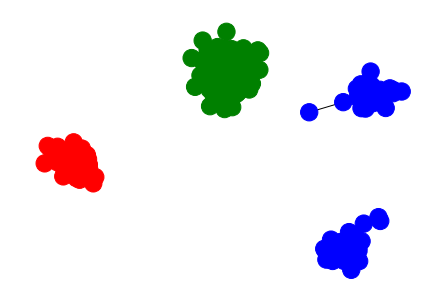

In [62]:
color_map = []
colors_list = ['blue', 'green', 'red', 'orange', 'black', 'gray', 'yellow']

for node in g:
  color_map.append(colors_list[colors[node]])

nx.draw(g, node_color=color_map)
plt.show()

# Put it all in a class: KEigenvectorAlgorithm

Here we build a class from the above tested functions - `KEigenvectorAlgorithm`

In [119]:
import numpy as np
from numpy.linalg import inv
from scipy.linalg import sqrtm, eigh
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

class KEigenvectorAlgorithm:
  def __init__(self, edgeList):
    self.edgeList = edgeList
    self.uncoloredGraph = self.__createGraph()
    self.coloredGraph = self.__createGraph()
    self.clustered = False
    self.kmeansColors = None

  def __createGraph(self):
    g = nx.Graph()

    for edge in self.edgeList:
      g.add_edge(edge[0], edge[1])

    return g

  def __createAffinityMatrix(self):
    maxID = self.edgeList.max()

    A = np.zeros(shape=(maxID + 1, maxID + 1))

    for edge in self.edgeList:
      fromNode = edge[0]
      toNode = edge[1]

      A[fromNode][toNode] = 1

    return A

  def __createLaplacianMatrix(self, A):
    D = np.diag(A.sum(axis=1))
    L = ((sqrtm(inv(D))).dot(A)).dot(sqrtm(inv(D)))

    def check_symmetric(a, rtol=1e-05, atol=1e-08):
        return np.allclose(a, a.T, rtol=rtol, atol=atol)

    assert check_symmetric(L)

    return L

  def __createX(self, L, k):

    eigenVals, eigenVecs = eigh(L, eigvals=(len(L) - k - 1, len(L) - 1))
    X = eigenVecs
    
    return X

  def __createY(self, X):
    Y = np.zeros(shape=X.shape)
    for i in range(Y.shape[0]):
      renomalizationFactor = np.sqrt(np.sum(np.square(X[i])))
      for j in range(Y.shape[1]):
        Y[i][j] = X[i][j] / renomalizationFactor

    return Y

  def __runKMeans(self, Y, k):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(Y)

    colors = kmeans.labels_

    return colors

  def run(self, k):
    A = self.__createAffinityMatrix()
    L = self.__createLaplacianMatrix(A)
    X = self.__createX(L, k)

    # X is already normalized so we don't need to run __create(Y)?
    # Y = self.__createY(X)
    
    self.kmeansColors = self.__runKMeans(X, k)
    self.clustered = True

  def plotOriginalGraph(self):
    nx.draw(self.uncoloredGraph)
    plt.show()

  def plotClusteredGraph(self):
    assert self.clustered

    colors_list = ['blue', 'green', 'red', 'orange', 'purple', 'gray', 'yellow', 'pink', 'black']
    color_map = []

    for node in self.coloredGraph:
      color_map.append(colors_list[self.kmeansColors[node]])

    nx.draw(self.coloredGraph, node_color=color_map)
    plt.show()

# Testing

## Example 1

#### Read Data...

In [120]:
example1 = './data/example1.dat'

with open(example1) as file:
  lines = [line.rstrip().split(',') for line in file]

example1_edgeList = np.array(lines, dtype=int) - 1

#### Create instance of the KEigenvectorAlgorithm and plot original graph

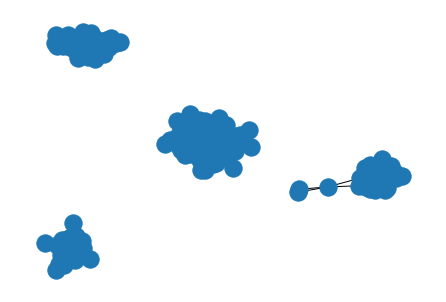

In [121]:
example1Graph = KEigenvectorAlgorithm(example1_edgeList)
example1Graph.plotOriginalGraph()

#### Cluster graph into `3 clusters`

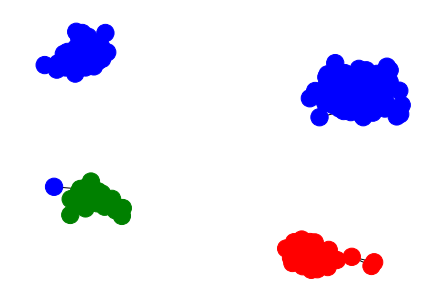

In [122]:
example1Graph.run(3)
example1Graph.plotClusteredGraph()

#### Cluster graph into `4 clusters`

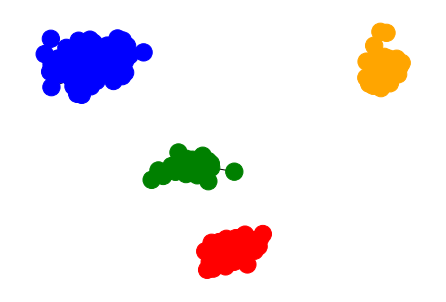

In [123]:
example1Graph.run(4)
example1Graph.plotClusteredGraph()

#### Cluster graph into `6 clusters`

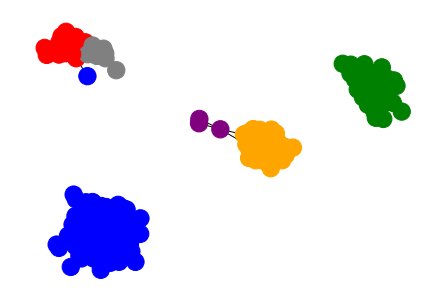

In [124]:
example1Graph.run(6)
example1Graph.plotClusteredGraph()

## Example 2

#### Read Data...

In [ ]:
example2 = './data/example2.dat'

with open(example2) as file:
  lines = [line.rstrip().split(',') for line in file]

example2_edgeList = np.array(lines, dtype=int) - 1

#### Create instance of the KEigenvectorAlgorithm and plot original graph

The KEigenvectorAlgorithm ignores the weights, which makes sense since they are all 1...

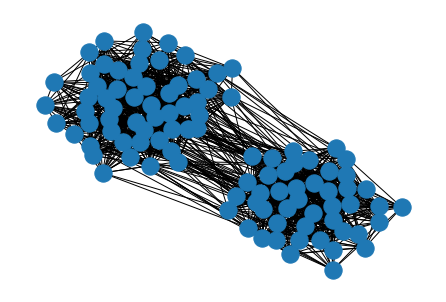

In [125]:
example2Graph = KEigenvectorAlgorithm(example2_edgeList)
example2Graph.plotOriginalGraph()

#### Cluster graph into `2 clusters`

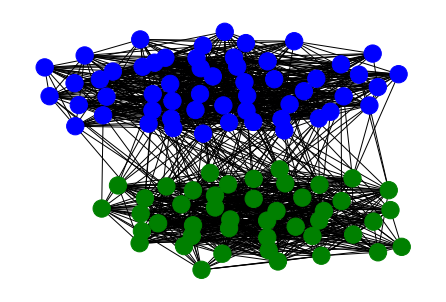

In [126]:
example2Graph.run(2)
example2Graph.plotClusteredGraph()

#### Cluster graph into `3 clusters`

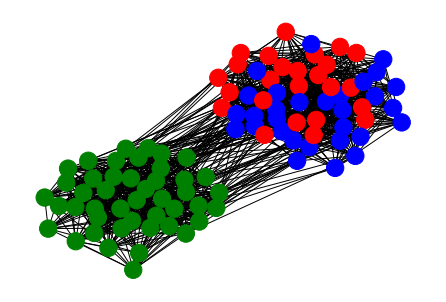

In [127]:
example2Graph.run(3)
example2Graph.plotClusteredGraph()

#### Cluster graph into `4 clusters`

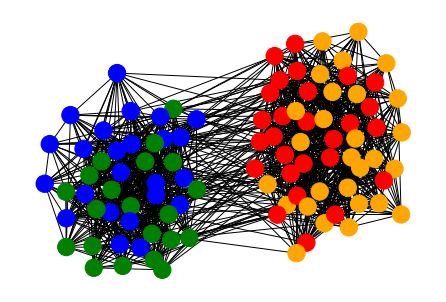

In [130]:
example2Graph.run(4)
example2Graph.plotClusteredGraph()